In [1]:
println("hello world")


hello world


In [5]:
# function to calculate the volume of a sphere
function sphere_vol(r)
    # julia allows Unicode names (in UTF-8 encoding)
    # so either "pi" or the symbol π can be used
    return 4/3*pi*r^3
end

# functions can also be defined more succinctly
quadratic(a, sqr_term, b) = (-b + sqr_term) / 2a

# calculates x for 0 = a*x^2+b*x+c, arguments types can be defined in function definitions
function quadratic2(a::Float64, b::Float64, c::Float64)
    # unlike other languages 2a is equivalent to 2*a
    # a^2 is used instead of a**2 or pow(a,2)
    sqr_term = sqrt(b^2-4a*c)
    r1 = quadratic(a, sqr_term, b)
    r2 = quadratic(a, -sqr_term, b)
    # multiple values can be returned from a function using tuples
    # if the return keyword is omitted, the last term is returned
    r1, r2
end

vol = sphere_vol(3)
# @printf allows number formatting but does not automatically append the \n to statements, see below
using Printf
@printf "volume = %0.3f\n" vol 

volume = 113.097


In [3]:
quad1, quad2 = quadratic2(2.0, -2.0, -12.0)
println("result 1: ", quad1)

result 1: 3.0


In [4]:
println("result 2: ", quad2)

result 2: -2.0


In [6]:
using CUDAdrv; CUDAdrv.name(CuDevice(0))

┌ Info: Precompiling CUDAdrv [c5f51814-7f29-56b8-a69c-e4d8f6be1fde]
└ @ Base loading.jl:1323


"GeForce RTX 2080 SUPER"

┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1278
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1278
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278


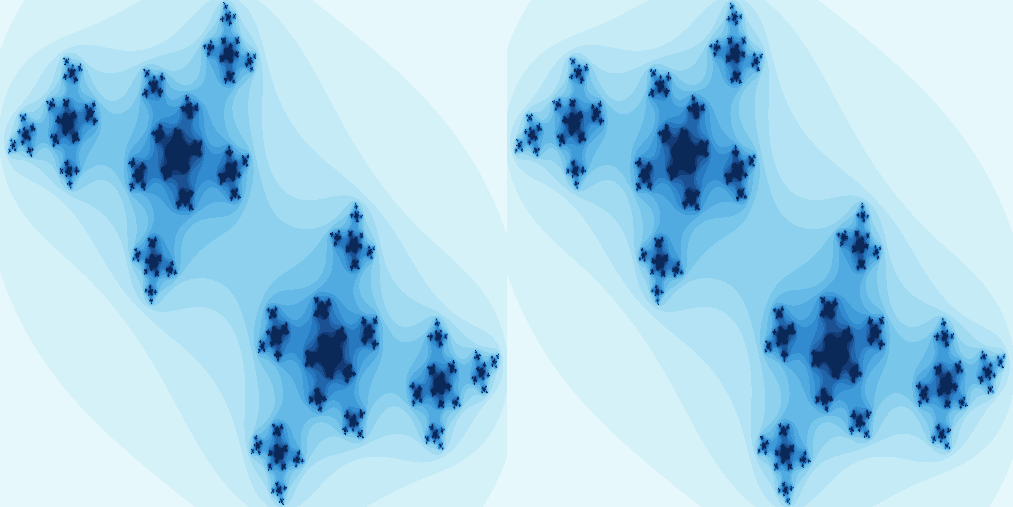

In [4]:
using CuArrays, FileIO, Colors, GPUArrays, BenchmarkTools, ImageShow
using CuArrays: CuArray
"""
The function calculating the Julia set
"""
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end
range = 100:50:2^12
cutimes, jltimes = Float64[], Float64[]
function run_bench(in, out)
  # use dot syntax to apply `juliaset` to each elemt of q_converted 
  # and write the output to result
  out .= juliaset.(in, 16)
  # all calls to the GPU are scheduled asynchronous, 
  # so we need to synchronize
  GPUArrays.synchronize(out)
end
# store a reference to the last results for plotting
last_jl, last_cu = nothing, nothing
for N in range
  w, h = N, N
  q = [ComplexF32(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5]
  for (times, Typ) in ((cutimes, CuArray), (jltimes, Array))
    # convert to Array or CuArray - moving the calculation to CPU/GPU
    q_converted = Typ(q)
    result = Typ(zeros(UInt8, size(q)))
    for i in 1:10 # 5 samples per size
      # benchmarking macro, all variables need to be prefixed with $
      t = Base.@elapsed begin
				run_bench(q_converted, result)
      end
      global last_jl, last_cu # we're in local scope
      if result isa CuArray
        last_cu = result
      else
      	last_jl = result
      end
      push!(times, t)
    end
  end
end

cu_jl = hcat(Array(last_cu), last_jl)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))

In [5]:
using Plots; plotly()
x = repeat(range, inner = 10)
speedup = jltimes ./ cutimes
Plots.scatter(
  log2.(x), [speedup, fill(1.0, length(speedup))], 
  label = ["cuda" "cpu"], markersize = 2, markerstrokewidth = 0,
  legend = :right, xlabel = "2^N", ylabel = "speedup"
)

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/jkh/.julia/packages/Plots/M1wcx/src/backends.jl:373


<!DOCTYPE html>
 
 
 Plots.jl